In [51]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict


In [38]:
df_cannabis = pd.read_csv("cannabis_full.csv")
df_cannabis.head(n=2)

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Part One: Binary Classification**

In [39]:
df_is = df_cannabis[(df_cannabis["Type"] == "sativa") | (df_cannabis["Type"] == "indica")]

In [40]:
df_is = df_is.drop(["Effects", "Flavor", "Strain"], axis=1)
df_is = df_is.dropna()

In [41]:
X = df_is.drop("Type", axis=1)
y = df_is["Type"]

**Q1: LDA**

I will be using ROC-AUC to evaluate the best of the LDA models. ROC-AUC does not only prioritize one category, and is instead a balance of the false positive rate and the true positive rate.

In [42]:
ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "drop"
)

In [53]:
pipeline = Pipeline(
  [("selection", ct),
  ("lda", LinearDiscriminantAnalysis(solver="lsqr"))]
).set_output(transform="pandas")

param = {"lda__shrinkage": ["auto", 0.1, 0.33, 0.5, 0.75, 0.9]}

gscv = GridSearchCV(pipeline, param, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=3)

,lda__shrinkage,scores
0,auto,0.934347
4,0.75,0.932210
3,0.5,0.932204


With automatic shrinkage using the Ledoit-Wolf lemma, we get a cross-validated ROC-AUC score of 0.934. Originally, I tuned using the solver as well, but the scores from both the eigenvalue decomposition and the least squares solutions were the same. For simplicity, I chose least squares solution as the solver and tuned on the shrinkage.

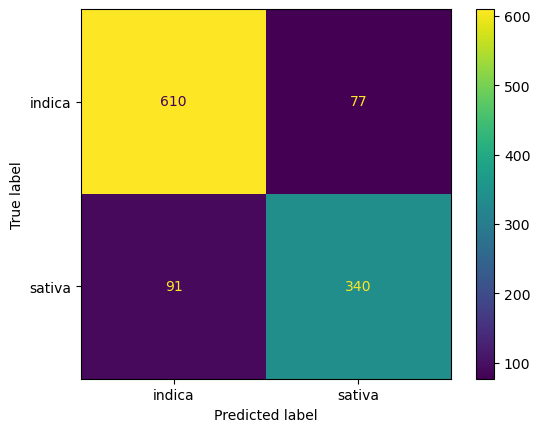

In [64]:
lda_pipeline = Pipeline(
  [("selection", ct),
  ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"))]
).set_output(transform="pandas")

y_pred = cross_val_predict(lda_pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

**Q2: QDA**

I will be using ROC-AUC to evaluate the best of the QDA models. ROC-AUC does not only prioritize one category, and is instead a balance of the false positive rate and the true positive rate.

In [62]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [63]:
pipeline = Pipeline(
  [("selection", ct),
  ("qda", QuadraticDiscriminantAnalysis())]
).set_output(transform="pandas")

param = {"qda__reg_param": [0.1, 0.33, 0.5, 0.75, 0.9]}

gscv = GridSearchCV(pipeline, param, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=3)

,qda__reg_param,scores
4,0.90,0.872736
3,0.75,0.824676
2,0.50,0.793137


With a regularization parameter of 0.9, we get a cross-validated ROC-AUC score of 0.873 for the QDA model.

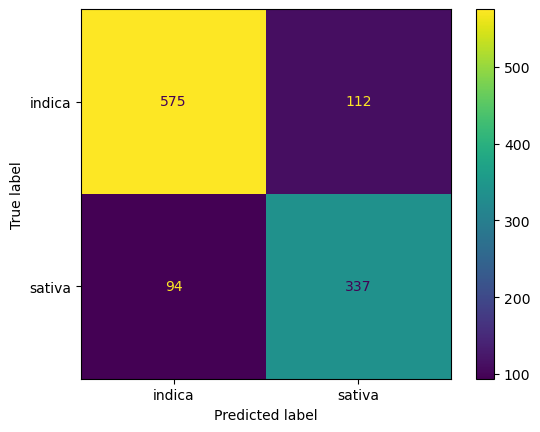

In [65]:
qda_pipeline = Pipeline(
  [("selection", ct),
  ("qda", QuadraticDiscriminantAnalysis(reg_param=0.9))]
).set_output(transform="pandas")

y_pred = cross_val_predict(qda_pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

**Q3: SVC**

I will be using ROC-AUC to evaluate the best of the SVC models. ROC-AUC does not only prioritize one category, and is instead a balance of the false positive rate and the true positive rate.

In [77]:
pipeline = Pipeline(
  [("selection", ct),
  ("svc", SVC(kernel="linear"))]
).set_output(transform="pandas")

parameter = {"svc__C": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10]}

gscv = GridSearchCV(pipeline, parameter, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=3)

,svc__C,scores
0,0.001,0.933206
1,0.010,0.927034
2,0.100,0.924187


With a regularization parameter of 0.001, we get a cross-validated ROC-AUC score of 0.933 for the SVC model.

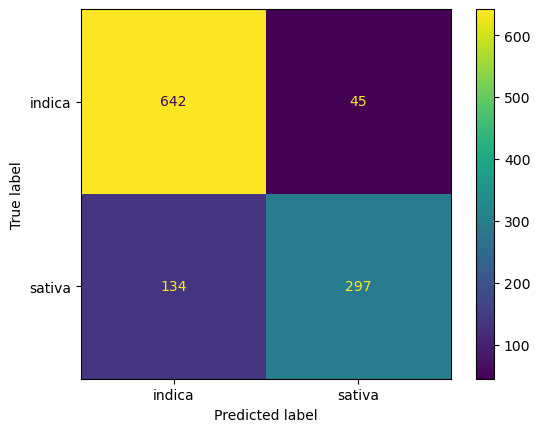

In [78]:
svc_pipeline = Pipeline(
  [("selection", ct),
  ("svc", SVC(kernel="linear", C=0.001))]
).set_output(transform="pandas")

y_pred = cross_val_predict(svc_pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

**Q4: SVM**

I will be using ROC-AUC to evaluate the best of the SVM models. ROC-AUC does not only prioritize one category, and is instead a balance of the false positive rate and the true positive rate.

In [76]:
pipeline = Pipeline(
  [("selection", ct),
  ("svc", SVC(kernel="poly"))]
).set_output(transform="pandas")

parameter = {"svc__C": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10]}

gscv = GridSearchCV(pipeline, parameter, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=3)

,svc__C,scores
8,10.0,0.887994
7,5.0,0.887340
6,2.0,0.875270


With a regularization parameter of 10, we get a cross-validated ROC-AUC score of 0.888 for the SVM model (with a polynomial kernel).

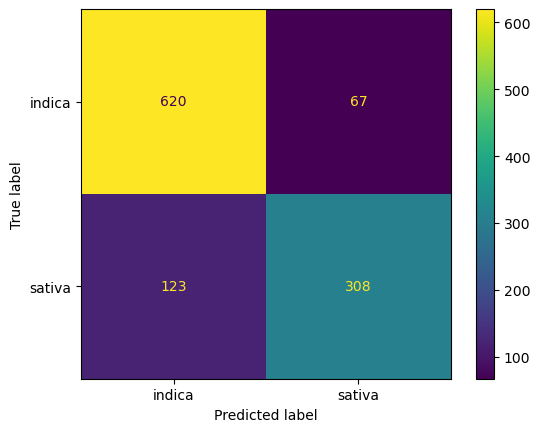

In [79]:
svm_pipeline = Pipeline(
  [("selection", ct),
  ("svc", SVC(kernel="poly", C=10))]
).set_output(transform="pandas")

y_pred = cross_val_predict(svm_pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()